## Sentiment Analysis w/ Pipeline Models
In this notebook, I will attempt to classifiy the recommended and non-recommended reviews using some baselien classifier models, such as Naive Bayes and Logisitc Regression. We'll compare each model using a confusion matrix as well as print a classificaiton report to get detailed metrics on the performances of the models.

In [14]:
import tensorflow as tf
print(tf.__version__)
import keras
import shap

2.6.0


In [15]:
import numpy as np
import pandas as pd
import pprint
from IPython.display import Image, SVG
import stylecloud
import matplotlib.pyplot as plt
import seaborn as sns

import time
import re
import os
import ast
import time
import json
import sys
import gensim
from gensim.models import Word2Vec, KeyedVectors
from gensim.test.utils import datapath
import nltk
import spacy
from collections import Counter, defaultdict
from itertools import chain

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, ConfusionMatrixDisplay
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Embedding, concatenate
import keras.utils
from keras.layers.recurrent import LSTM
from keras.layers.wrappers import Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras.optimizers
from keras.utils.vis_utils import model_to_dot


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

import warnings
warnings.filterwarnings('ignore')

In [16]:
elden_ring_reviews = pd.read_csv("elden_ring_reviews_processed.csv")
elden_ring_reviews.drop(columns='Unnamed: 0', inplace=True)

In [17]:
elden_ring_reviews.head()

,recommendationid,author,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,tokenized_texts,review_length
0,112052982,"{'steamid': '76561197971854668', 'num_games_ow...",english,First time with a Dark Souls type game and lov...,1647106589,1647106589,True,13373,1063,0.969001,0,True,False,False,"['time', 'dark', 'souls', 'type', 'game', 'lov...",108
1,111180228,"{'steamid': '76561198142415989', 'num_games_ow...",english,"The note said ""chest ahead"" at the edge of a c...",1645984692,1645984692,True,10448,6200,0.968309,144,True,False,False,"['note', 'say', 'chest', 'ahead', 'edge', 'cli...",161
2,111834761,"{'steamid': '76561197996565477', 'num_games_ow...",english,you can hug a woman,1646786974,1646786974,True,7580,2737,0.965731,81,False,False,False,"['hug', 'woman']",19
3,111321870,"{'steamid': '76561197977618010', 'num_games_ow...",english,If you rush you can make it the hardest Souls ...,1646160050,1646160090,True,4839,63,0.965078,0,True,False,False,"['rush', 'hard', 'souls', 'game', 'play', 'bit...",496
4,111347314,"{'steamid': '76561198101636446', 'num_games_ow...",english,"""Try jumping""\n*20 bloodstains surrounding the...",1646188418,1646188418,True,7403,3884,0.961223,0,True,False,False,"['try', 'jump', '20', 'bloodstain', 'surround'...",54


In [18]:
elden_ring_reviews[elden_ring_reviews['voted_up']==False]

,recommendationid,author,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,tokenized_texts,review_length
53,111413568,"{'steamid': '76561198072795989', 'num_games_ow...",english,The game itself is great but [b]dont buy the D...,1646266096,1646655707,False,5703,454,0.806052,0,True,False,False,"['game', 'great', 'buy', 'deluxe', 'adventure'...",382
60,110922981,"{'steamid': '76561198042661879', 'num_games_ow...",english,"Struggling to maintain 60FPS/1080p on a 3080, ...",1645753740,1645756397,False,9974,968,0.771891,0,True,False,False,"['struggle', 'maintain', '3080', 'massive', 's...",317
61,110932113,"{'steamid': '76561198152543417', 'num_games_ow...",english,stuttering like crazy no matter what settings ...,1645760969,1645760969,False,2469,146,0.763107,0,True,False,False,"['stutter', 'like', 'crazy', 'matter', 'setting']",52
65,110936973,"{'steamid': '76561198072026241', 'num_games_ow...",english,Elden Ring? More like stutter ring,1645764542,1646554112,False,1744,1731,0.753324,122,False,False,False,"['elden', 'ring', 'like', 'stutter', 'ring']",34
69,110926388,"{'steamid': '76561197990082325', 'num_games_ow...",english,"Trying to fight Tree Sentinel with stutters, s...",1645756631,1645756631,False,386,25,0.740533,41,True,False,False,"['try', 'fight', 'tree', 'sentinel', 'stutter'...",108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155351,110924917,"{'steamid': '76561198054731627', 'num_games_ow...",english,no ultrawide support :/,1645755322,1645767000,False,0,0,0.000000,0,True,False,False,"['ultrawide', 'support']",23
155353,110924905,"{'steamid': '76561198137075062', 'num_games_ow...",english,"even on lowest possible settings, constant fla...",1645755311,1645755385,False,0,0,0.000000,0,True,False,False,"['low', 'possible', 'setting', 'constant', 'fl...",160
155354,110924904,"{'steamid': '76561198873224798', 'num_games_ow...",english,Forcing PC users to use a controller to get th...,1645755310,1645755310,False,0,0,0.000000,0,True,False,False,"['force', 'pc', 'user', 'use', 'controller', '...",294
155356,110924899,"{'steamid': '76561197993892537', 'num_games_ow...",english,10/10 can't even play the game.,1645755308,1645755308,False,0,0,0.000000,0,False,False,False,"['play', 'game']",31


In [19]:
elden_ring_reviews[elden_ring_reviews['voted_up']==False].shape

(15282, 16)

In [21]:
def review_tokenizer(text):
    return [token.lemma_.lower() for token in nlp(text) if not token.is_stop and not token.is_punct and str(token).isalnum()]


nlp = spacy.load('en_core_web_sm')

extra_stop_words = ['\n', '\t']

nlp.Defaults.stop_words.update(extra_stop_words)

tokenized_texts = []

texts = elden_ring_reviews.loc[:, 'review'].tolist()

In [23]:
#This is going to take a while..

#Since the datatype isn't preserved from the previous notebook to this one, we have to tokenize the texts again:

for i, text in enumerate(texts):
    if i % 500 == 0:
        print('Text ', i)
    
    if pd.isnull(text):
        tokenized_texts.append(['NO REVIEW']) #maybe dashes are better than a word in order to distinguish
    else:
        tokenized_texts.append(review_tokenizer(text))

Text  0
Text  500
Text  1000
Text  1500
Text  2000
Text  2500
Text  3000
Text  3500
Text  4000
Text  4500
Text  5000
Text  5500
Text  6000
Text  6500
Text  7000
Text  7500
Text  8000
Text  8500
Text  9000
Text  9500
Text  10000
Text  10500
Text  11000
Text  11500
Text  12000
Text  12500
Text  13000
Text  13500
Text  14000
Text  14500
Text  15000
Text  15500
Text  16000
Text  16500
Text  17000
Text  17500
Text  18000
Text  18500
Text  19000
Text  19500
Text  20000
Text  20500
Text  21000
Text  21500
Text  22000
Text  22500
Text  23000
Text  23500
Text  24000
Text  24500
Text  25000
Text  25500
Text  26000
Text  26500
Text  27000
Text  27500
Text  28000
Text  28500
Text  29000
Text  29500
Text  30000
Text  30500
Text  31000
Text  31500
Text  32000
Text  32500
Text  33000
Text  33500
Text  34000
Text  34500
Text  35000
Text  35500
Text  36000
Text  36500
Text  37000
Text  37500
Text  38000
Text  38500
Text  39000
Text  39500
Text  40000
Text  40500
Text  41000
Text  41500
Text  42000
Text

In [24]:
elden_ring_reviews['tokenized_texts'] = tokenized_texts

## Simple Sentiment Analysis
Simple sentiment analysis with Count Vectorizer. I will run Naive Bayes, Support Vector Machine, and Logistic Regression on our data.

In [25]:
# train_test_split ->

#Count vec -> tfidf tranf -> classification algorithm.

In [26]:
#Since the tokens are in a list, we convert them to single strings for each record in the data

tokenized_sentences = []
for lis in elden_ring_reviews.loc[: , 'tokenized_texts']:
    tokenized_sentences.append(' '.join(lis))

In [27]:
elden_ring_reviews['tokenized_sentences'] = tokenized_sentences

In [28]:
#Making a new column converting our target attribute to the integer datatype

elden_ring_reviews['recommended'] = elden_ring_reviews['voted_up'].astype(int)

In [29]:
y = np.array([1 if rec == 1.0 else 0.0 for rec in elden_ring_reviews['recommended']])

In [30]:
X = elden_ring_reviews['tokenized_sentences']
#We must stratify y since we have less non-recommended samples

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3, test_size=0.25, stratify=y)

In [31]:
elden_ring_reviews['recommended'].value_counts()

#Now the train and test sets should have equal proportions of recommended values


1    140085
0     15282
Name: recommended, dtype: int64

In [32]:
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(116525,)
(38842,)
(116525,)
(38842,)


We'll try a few different classification algorithms here, such as Naive Bayes, SVM, and Logistic Regression, and compare each one's performance.

In [33]:
pipeline = Pipeline([('vectorize', CountVectorizer(ngram_range=(1, 3))),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
                    ])

In [34]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print('Accuracy: {}'.format(accuracy_score(y_test, y_pred)))
print('F1 Score: {}'.format(f1_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

Accuracy: 0.9023479738427476
F1 Score: 0.9486286991264306
              precision    recall  f1-score   support

         0.0       1.00      0.01      0.01      3821
         1.0       0.90      1.00      0.95     35021

    accuracy                           0.90     38842
   macro avg       0.95      0.50      0.48     38842
weighted avg       0.91      0.90      0.86     38842



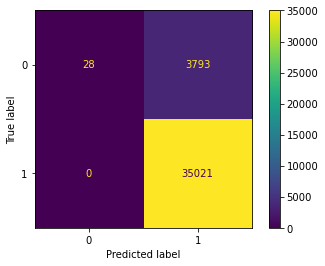

In [35]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(cm)
disp.plot()

It's quite interesting that it predicts the positive labels extremely well but doesn't get virtually any of the non-recommended labels.

In [36]:
pipeline = Pipeline([('vectorize', CountVectorizer(ngram_range=(1, 3))),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier()),
                    ])

In [37]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print('Accuracy: {}'.format(accuracy_score(y_test, y_pred)))
print('F1 Score: {}'.format(f1_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

Accuracy: 0.9236651047834818
F1 Score: 0.9591862017702039
              precision    recall  f1-score   support

         0.0       0.85      0.27      0.41      3821
         1.0       0.93      0.99      0.96     35021

    accuracy                           0.92     38842
   macro avg       0.89      0.63      0.69     38842
weighted avg       0.92      0.92      0.91     38842



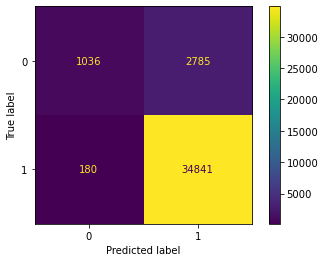

In [38]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(cm)
disp.plot()

This model does a better job of correctly predicting the non-recommended records.

In [39]:
pipeline = Pipeline([('vect', CountVectorizer(ngram_range=(1, 3))),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(max_iter=1000)),
               ])

In [40]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print('Accuracy: {}'.format(accuracy_score(y_test, y_pred)))
print('F1 Score: {}'.format(f1_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

Accuracy: 0.9401421142062716
F1 Score: 0.9671976184765586
              precision    recall  f1-score   support

         0.0       0.75      0.59      0.66      3821
         1.0       0.96      0.98      0.97     35021

    accuracy                           0.94     38842
   macro avg       0.85      0.78      0.81     38842
weighted avg       0.94      0.94      0.94     38842



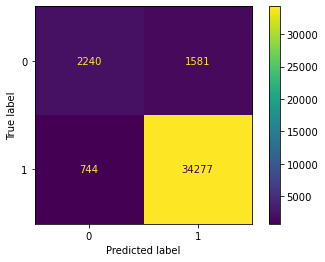

In [41]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(cm)
disp.plot()

Logisitc Regression performs better than Naive Bayes and the SGD Classifier, but it still misclassifies a lot of the non-recommended reviews. 

## Closing Remarks:

* And this model built on top of that and does a much better job of classifying both types of review posts. It managed to correctly predict more non-recommended posts than it does recommended posts.


* What does make this more difficult is the nature of Steam reviews. Some reviews could have jokes, sarcasm, or be something that isn't one's account of the game but rather just a general statement about it.

Again, since we are still misclassifying many non-recommended reviews, I want to maximize the amount of these reviews we correctly classify. In the next notebook, we'll optimize sentiment classification utilizing deep learning and HuggingFace transformer models.